## **Import Library**

In [ ]:
# !pip install toad

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import toad
from toad.metrics import KS, AUC
from toad.plot import bin_plot, badrate_plot
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import shap

## **Load Data Clean**

In [ ]:
from google.colab import drive
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Mount Google Drive
drive.mount('/content/drive')

# Tentukan path folder yang sesuai setelah Drive di-mount
folder_path = '/content/drive/MyDrive/data_homecredit/'

# Membaca file Parquet
app_train = pd.read_parquet(f'{folder_path}application_train_cleaned.parquet')
bb = pd.read_parquet(f'{folder_path}bureau_balance.parquet')
bureau = pd.read_parquet(f'{folder_path}bureau_cleaned.parquet')
ccb = pd.read_parquet(f'{folder_path}credit_card_balance_cleaned.parquet')
installments = pd.read_parquet(f'{folder_path}ipayment_cleaned.parquet')
pos_cash = pd.read_parquet(f'{folder_path}POS_CASH_balance_cleaned.parquet')
previous = pd.read_parquet(f'{folder_path}prev_app_cleaned.parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Feature Engineering & Join Data**

### Agregasi Bureau data

In [ ]:
bb

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [ ]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,0,91323.00,0.0,0.0,0.0,Consumer credit,-131
1,215354,5714463,Active,currency 1,-208,0,1075.0,-897.0,0,225000.00,171342.0,0.0,0.0,Credit card,-20
2,215354,5714464,Active,currency 1,-203,0,528.0,-897.0,0,464323.50,0.0,0.0,0.0,Consumer credit,-16
3,215354,5714465,Active,currency 1,-203,0,-330.0,-897.0,0,90000.00,0.0,0.0,0.0,Credit card,-16
4,215354,5714466,Active,currency 1,-629,0,1197.0,-897.0,0,2700000.00,0.0,0.0,0.0,Consumer credit,-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716410,259355,5057750,Active,currency 1,-44,0,-30.0,-897.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19
1716411,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493
1716412,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,0,15570.00,0.0,0.0,0.0,Consumer credit,-967
1716413,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508


TARGET              0      1
STATUS_BIN                  
heavy_late     160053  13017
light_late      77847   6553
moderate_late    4517    743
no_late           705     55


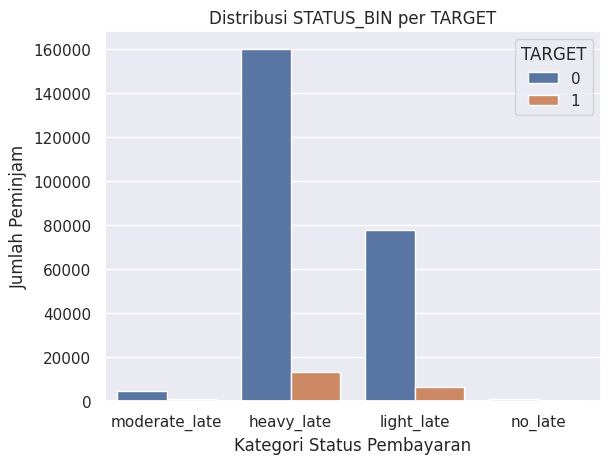

Korelasi dengan TARGET:
 TARGET                 1.000000
MEAN_BUREAU_STATUS     0.021741
AVG_DAYS_OVERDUE       0.006899
AMT_CREDIT_SUM_DEBT    0.001897
DEBT_CREDIT_RATIO      0.000787
AMT_CREDIT_SUM        -0.018020
Name: TARGET, dtype: float64


In [ ]:
# 1. Rata-rata bulan pelaporan dari bureau balance
bb_agg_months = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# 2. Gabungkan ke bureau
bureau_semi_join = bureau.merge(bb_agg_months, on='SK_ID_BUREAU', how='left')

# 3. Total jumlah kredit dan hutang per peminjam
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

# ==================== Step 2: Skor Keterlambatan dari bb ====================

# 4. Mapping status ke skor numerik
status_map = {'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}
bb['STATUS_NUM'] = bb['STATUS'].map(status_map)

# 5. Rata-rata skor status per SK_ID_BUREAU
bb_agg_status = bb.groupby('SK_ID_BUREAU')['STATUS_NUM'].mean().reset_index(name='MEAN_BUREAU_STATUS')

# 6. Gabungkan ke bureau dan hitung rata-rata per SK_ID_CURR
bureau_status = bureau.merge(bb_agg_status, on='SK_ID_BUREAU', how='left')
status_by_curr = bureau_status.groupby('SK_ID_CURR')['MEAN_BUREAU_STATUS'].mean().reset_index()

# 7. Tambahkan STATUS_BIN (kategori)
def categorize_status(x):
    if x == 0:
        return 'no_late'
    elif x <= 1:
        return 'light_late'
    elif x <= 3:
        return 'moderate_late'
    else:
        return 'heavy_late'

status_by_curr['STATUS_BIN'] = status_by_curr['MEAN_BUREAU_STATUS'].apply(categorize_status)

# ==================== Step 3: Fitur Tambahan ====================

# 8. Rata-rata keterlambatan hari dari bureau
avg_overdue = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index(name='AVG_DAYS_OVERDUE')

# ==================== Step 4: Gabungkan semua ke aplikasi ====================

app_train_enriched = app_train.copy()

# Gabungkan fitur-fitur
app_train_enriched = app_train_enriched.merge(bureau_agg, on='SK_ID_CURR', how='left')
app_train_enriched = app_train_enriched.merge(status_by_curr[['SK_ID_CURR', 'MEAN_BUREAU_STATUS', 'STATUS_BIN']], on='SK_ID_CURR', how='left')
app_train_enriched = app_train_enriched.merge(avg_overdue, on='SK_ID_CURR', how='left')

# Handle missing values
app_train_enriched[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'MEAN_BUREAU_STATUS', 'AVG_DAYS_OVERDUE']] = \
    app_train_enriched[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'MEAN_BUREAU_STATUS', 'AVG_DAYS_OVERDUE']].fillna(0)

# Tambahkan rasio utang/kredit
app_train_enriched['DEBT_CREDIT_RATIO'] = app_train_enriched['AMT_CREDIT_SUM_DEBT'] / \
                                          app_train_enriched['AMT_CREDIT_SUM'].replace(0, 1)

# ==================== Step 5: Analisis dan Visualisasi ====================

# Distribusi STATUS_BIN berdasarkan TARGET
print(app_train_enriched.groupby(['STATUS_BIN', 'TARGET']).size().unstack(fill_value=0))

# Visualisasi
sns.countplot(data=app_train_enriched, x='STATUS_BIN', hue='TARGET')
plt.title('Distribusi STATUS_BIN per TARGET')
plt.xlabel('Kategori Status Pembayaran')
plt.ylabel('Jumlah Peminjam')
plt.show()

# Korelasi fitur numerik dengan TARGET
correlation = app_train_enriched[['TARGET', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
                                  'MEAN_BUREAU_STATUS', 'AVG_DAYS_OVERDUE',
                                  'DEBT_CREDIT_RATIO']].corr()
print("Korelasi dengan TARGET:\n", correlation['TARGET'].sort_values(ascending=False))


In [ ]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681632,0.535276,0.9876,0.6042,0.9782,0.4583,0.9876,0.6042,0.2898,No,0.0,0.0,0.0,0.0,-273.0,0.0,0.0,0.0,0.0,0.0,1.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,Laborers,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,0.115992,0.535276,0.9727,0.0833,0.9727,0.0833,0.9727,0.0833,0.0214,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30750

In [ ]:
app_train_enriched

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,MEAN_BUREAU_STATUS,STATUS_BIN,AVG_DAYS_OVERDUE,DEBT_CREDIT_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,865055.565,245781.00,1.108831,moderate_late,0.0,0.284122
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.000000,heavy_late,0.0,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,189037.800,0.00,0.000000,heavy_late,0.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.00,0.000000,NaN,0.0,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,146250.000,0.00,0.000000,heavy_late,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681632,0.535276,0.9876,0.6042,0.9782,0.4583,0.9876,0.6042,0.2898,No,0.0,0.0,0.0,0.0,-273.0,0.0,0.0,0.0,0.0

✅ AMT_CREDIT_SUM,

Total jumlah kredit yang pernah dimiliki pemohon dari catatan di Credit Bureau.

= Menunjukkan eksposur kredit seseorang. Kredit tinggi bisa berarti dipercaya, tapi juga bisa menunjukkan beban hutang tinggi.

✅ AMT_CREDIT_SUM_DEBT

Total hutang yang masih tersisa (belum dilunasi).

= Memberi sinyal apakah orang ini punya tanggung jawab keuangan yang belum diselesaikan. Nilai tinggi bisa menunjukkan risiko default lebih besar.

✅ MEAN_BUREAU_STATUS

Rata-rata status keterlambatan pembayaran (C: current → bagus, 5: paling buruk).

= Ini indikator kualitas historis pembayaran. Semakin tinggi angkanya, semakin buruk track record-nya → fitur prediktif yang sangat kuat.

✅ AVG_DAYS_OVERDUE

Rata-rata jumlah hari keterlambatan pembayaran.

= Semakin besar nilainya, semakin besar kecenderungan pemohon untuk menunda pembayaran, yang merupakan sinyal risiko tinggi.

Saat modelling untuk logistic regression pilih salah satu **STATUS_BIN atau MEAN_BUREAU_STATUS**

### **Agregasi Payment installments**

In [ ]:
# Periksa nama kolom yang ada dalam dataset installments
print(installments.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')


In [ ]:
installments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13602491,2006721,442291,1.0,3,-1311.0,-1318.0,2934.225,2934.225
13602492,1126000,428449,0.0,12,-301.0,-302.0,6793.470,6750.000
13602493,1519070,444122,1.0,5,-399.0,-407.0,4363.830,4363.830
13602494,2784672,444977,0.0,4,-157.0,-157.0,373.005,373.005


In [ ]:
# Agregasi data pembayaran cicilan
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Menghitung selisih antara jumlah cicilan dan pembayaran
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']

# Menghapus kolom SK_ID_CURR setelah agregasi
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

In [ ]:
prev_installments

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,XAP,Approved,-73,Cash through the bank,XAP,Unknown,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,17284.275,17284.275,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,Y,1,0.000000,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,125943.075,125943.075,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,Y,1,0.000000,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,135546.615,135546.615,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,Y,1,0.000000,XNA,Approved,-512,Cash through the bank,XAP,Unknown,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,563133.375,563133.375,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,Y,1,0.000000,Repairs,Refused,-781,Cash through the bank,HC,Unknown,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,365243.0,-831.0,-361.0,-537.0,-499.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,XAP,Approved,-544,Cash through the bank,XAP,Unknown,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0,353763.585,353763.585,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0,79271.865,79271.865,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0,115188.570,115188.570,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,Y,1,0.000000,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0,225834.660,225834.660,0.0


In [ ]:
# Memeriksa baris duplikat
duplicate_rows = prev_installments.duplicated()

# Menampilkan jumlah baris duplikat
print(f"Jumlah baris duplikat: {duplicate_rows.sum()}")

# Fungsi untuk menghitung dan menampilkan kolom dengan nilai missing
def check_nan(prev_installments):
    # Hitung nilai null
    null_values = prev_installments.isnull().sum()

    # Buat DataFrame untuk total nilai null dan persentase
    nvc = pd.DataFrame(null_values[null_values > 0].sort_values(), columns=['Total Null Values'])  # Hanya ambil kolom dengan nilai null
    nvc['Percentage'] = (nvc['Total Null Values'] / prev_installments.shape[0]) * 100
    nvc["Data Type"] = [prev_installments[col].dtype for col in nvc.index]  # Ambil tipe data dari kolom yang ada

    # Urutkan berdasarkan total nilai null dan persentase
    nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

    # Tampilkan hasil dengan gaya
    return nvc.style.background_gradient(cmap='Blues')

# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(prev_installments)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

Jumlah baris duplikat: 0


,Total Null Values,Percentage,Data Type
AMT_INSTALMENT,711380,42.592147,float64
AMT_PAYMENT,711380,42.592147,float64
DIFF_INSTALLMENT_PAYMENT,711380,42.592147,float64


In [ ]:
prev_installments[['AMT_INSTALMENT', 'AMT_PAYMENT', 'DIFF_INSTALLMENT_PAYMENT']].describe().T


,count,mean,std,min,25%,50%,75%,max
AMT_INSTALMENT,958834.0,235476.416917,341192.024867,0.00,56065.93875,114039.6075,255421.02375,3.007539e+07
AMT_PAYMENT,958834.0,238314.211433,368853.914991,0.09,54371.40750,110760.8850,247940.73000,3.007314e+07
DIFF_INSTALLMENT_PAYMENT,958834.0,-2837.794516,97560.419623,-3195000.00,0.00000,0.0000,0.00000,2.602349e+06


In [ ]:
# Isi missing values dengan 0
prev_installments['AMT_INSTALMENT'].fillna(0, inplace=True)
prev_installments['AMT_PAYMENT'].fillna(0, inplace=True)
prev_installments['DIFF_INSTALLMENT_PAYMENT'].fillna(0, inplace=True)

DIFF_INSTALMENT_PAYMENT, AMT_PAYMENT dan AMT_INSTALMENT saya akan mengisi nilai yang hilang dengan 0, karena masuk akal untuk mengasumsikan bahwa klien juga tidak memiliki aplikasi sebelumnya.

In [ ]:
# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(prev_installments)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

,Total Null Values,Percentage,Data Type


### **Agregasi Credit Card Balance**

In [ ]:
ccb

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,2702.70,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,0.0,0.0,0.0,0.0,0.000,2702.70,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,Active,0,0


In [ ]:
# Agregasi Credit Card Balance dengan fitur tambahan
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_CREDIT_LIMIT_ACTUAL',
                                     'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_POS_CURRENT']].sum().reset_index()

# Gabungkan dengan previous installment data
prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')



In [ ]:
# Memeriksa baris duplikat
duplicate_rows = prev_ccb.duplicated()

# Menampilkan jumlah baris duplikat
print(f"Jumlah baris duplikat: {duplicate_rows.sum()}")

# Fungsi untuk menghitung dan menampilkan kolom dengan nilai missing
def check_nan(prev_ccb):
    # Hitung nilai null
    null_values = prev_ccb.isnull().sum()

    # Buat DataFrame untuk total nilai null dan persentase
    nvc = pd.DataFrame(null_values[null_values > 0].sort_values(), columns=['Total Null Values'])  # Hanya ambil kolom dengan nilai null
    nvc['Percentage'] = (nvc['Total Null Values'] / prev_ccb.shape[0]) * 100
    nvc["Data Type"] = [prev_ccb[col].dtype for col in nvc.index]  # Ambil tipe data dari kolom yang ada

    # Urutkan berdasarkan total nilai null dan persentase
    nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

    # Tampilkan hasil dengan gaya
    return nvc.style.background_gradient(cmap='Blues')

# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(prev_ccb)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

Jumlah baris duplikat: 0


,Total Null Values,Percentage,Data Type
AMT_BALANCE,1577279,94.435743,float64
AMT_PAYMENT_TOTAL_CURRENT,1577279,94.435743,float64
AMT_CREDIT_LIMIT_ACTUAL,1577279,94.435743,float64
CNT_DRAWINGS_ATM_CURRENT,1577279,94.435743,float64
CNT_DRAWINGS_POS_CURRENT,1577279,94.435743,float64


In [ ]:
# prompt: cek describe dari kolom yang missing value saja di prev_ccb

# Get columns with missing values
missing_cols = prev_ccb.columns[prev_ccb.isnull().any()].tolist()

# Describe the columns with missing values
prev_ccb[missing_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
AMT_BALANCE,92935.0,1.993375e+06,3.112899e+06,-126000.0,0.0,567904.725,2.676474e+06,2.949212e+07
AMT_PAYMENT_TOTAL_CURRENT,92935.0,2.649352e+05,4.621774e+05,0.0,0.0,96997.500,3.645654e+05,3.007314e+07
AMT_CREDIT_LIMIT_ACTUAL,92935.0,5.351264e+06,5.061274e+06,0.0,1237500.0,3420000.000,8.550000e+06,3.285000e+07
CNT_DRAWINGS_ATM_CURRENT,92935.0,8.642309e+00,1.433982e+01,0.0,0.0,2.000,1.200000e+01,3.900000e+02
CNT_DRAWINGS_POS_CURRENT,92935.0,1.818251e+01,5.237194e+01,0.0,0.0,0.000,1.100000e+01,2.298000e+03


In [ ]:
# Identifikasi kolom yang memiliki missing values lebih dari 94%
threshold = 0.94
cols_to_drop = [col for col in prev_ccb.columns if prev_ccb[col].isnull().mean() > threshold]

# Drop kolom-kolom tersebut
prev_ccb = prev_ccb.drop(columns=cols_to_drop)

In [ ]:
# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(prev_ccb)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

,Total Null Values,Percentage,Data Type


### Agregasi Pos Cash Balance

In [ ]:
pos_cash

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [ ]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

In [ ]:
prev_pc

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,XAP,Approved,-73,Cash through the bank,XAP,Unknown,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,17284.275,17284.275,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,Y,1,0.000000,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,125943.075,125943.075,0.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,Y,1,0.000000,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,135546.615,135546.615,0.0,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,Y,1,0.000000,XNA,Approved,-512,Cash through the bank,XAP,Unknown,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,563133.375,563133.375,0.0,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,Y,1,0.000000,Repairs,Refused,-781,Cash through the bank,HC,Unknown,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,365243.0,-831.0,-361.0,-537.0,-499.0,0.0,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,XAP,Approved,-544,Cash through the bank,XAP,Unknown,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0,353763.585,353763.585,0.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0,79271.865,79271.865,0.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0,115188.570,115188.570,0.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,Y,1,0.000000,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0,225834.660,225834.660,0.0,0.0


In [ ]:
app_train_enriched

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,MEAN_BUREAU_STATUS,STATUS_BIN,AVG_DAYS_OVERDUE,DEBT_CREDIT_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,865055.565,245781.00,1.108831,moderate_late,0.0,0.284122
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.000000,heavy_late,0.0,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,189037.800,0.00,0.000000,heavy_late,0.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.00,0.000000,NaN,0.0,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,146250.000,0.00,0.000000,heavy_late,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681632,0.535276,0.9876,0.6042,0.9782,0.4583,0.9876,0.6042,0.2898,No,0.0,0.0,0.0,0.0,-273.0,0.0,0.0,0.0,0.0

### Train Full

In [ ]:
df_train_full = pd.merge(app_train_enriched, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [ ]:
df_train_full

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,MEAN_BUREAU_STATUS,STATUS_BIN,AVG_DAYS_OVERDUE,DEBT_CREDIT_RATIO,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_prev,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,865055.565,245781.00,1.108831,moderate_late,0.0,0.284122,1038818.0,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9.0,Y,1.0,0.000000,XAP,Approved,-606.0,XNA,XAP,Unknown,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0,219625.695,219625.695,0.000,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.000000,heavy_late,0.0,0.000000,1810518.0,Cash loans,98356.995,900000.0,1035882.0,0.0,900000.0,FRIDAY,12.0,Y,1.0,0.000000,XNA,Approved,-746.0,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0,1150977.330,1150977.330,0.000,0.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.000000,heavy_late,0.0,0.000000,2636178.0,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17.0,Y,1.0,0.000000,XAP,Approved,-828.0,Cash through the bank,XAP,Family,Refres

In [ ]:
df_train_full.to_parquet(
    'df_train_full.parquet',
    engine='pyarrow',
    index=False,
    compression='snappy'  # Kompresi cepat & umum, tetap jaga presisi
)

In [ ]:
df_loaded = pd.read_parquet('df_train_full.parquet', engine='pyarrow')
print(df_loaded.dtypes.equals(df_train_full.dtypes))  # Harus True
print(df_loaded.equals(df_train_full))                # Harus True jika semua data identik

True
True
